**Aluno:** Douglas Leite Leal Moura

**Matrícula:** 2020715184

**Trabalho Prático II - Machine Learning**

_Implementação do Algoritmo de Boosting_

## 1. Introdução

### 1.1 Objetivo

Nosso foco neste trabalho prático é ganhar experiência com o processo de Boosting. Você deverá implementar o processo de Boosting (visto em sala de aula) assumindo um problema de classificação binária com atributos categóricos. Em particular, você deverá realizar os experimentos utilizando o dataset tic-tac-toe, disponível em https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame.

Sua avaliação deverá seguir a metodologia de validação cruzada com 5 partições. A medida de eficácia a ser considerada é a taxa de erro simples. Você deverá implementar todo o processo de Boosting, e portanto não é permitido utilizar soluções prontas (embora não seja necessário implementar funções básicas).

A escolha da linguagem de programação é uma decisão do aluno.

### 1.2 Instruções

Este trabalho utiliza a bibliteca scikit-learn da linguagem Python (versão 3.6).

O ambiente virtual pode ser configurado mediante a execução dos seguintes comandos no terminal:

$ virtualenv -p python3 .env

$ source .env/bin/activate

$ pip install -r requirements.txt

A sequência de comandos abaixo faz os imports necessários para a execução dos experimentos:


In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.base import ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.multiclass import unique_labels

## 2. Conjunto de dados

O conjunto de dados foi importado utilizando Pandas, uma poderosa biblioteca Python criada para a manipulação e análise de dados.

O conjunto de dados é constituído por `958 exemplos` com `9 atributos`, que descrevem possíveis configurações de um tabuleiro de jogo da velha:

1. top-left-square: {x,o,b}
2. top-middle-square: {x,o,b}
3. top-right-square: {x,o,b}
4. middle-left-square: {x,o,b}
5. middle-middle-square: {x,o,b}
6. middle-right-square: {x,o,b}
7. bottom-left-square: {x,o,b}
8. bottom-middle-square: {x,o,b}
9. bottom-right-square: {x,o,b}
10. **Class: {positive,negative}**

Cada atributo indica a jogada realizada em um determinada posição do tabuleiro, que pode assumir 3 valores (`x`, `o` ou `b`). Por exemplo, o atributo indicado pela coluna `0` é o quadrado situado na esquerda superior do tabuleiro e o valor `x` indica que a jogada foi realizado pelo jogador `x`. Além disso, se ninguém jogou naquela posição, a posição estará em branco (b).

A classe (coluna 9) indica se o jogador x (positive) venceu ou perdeu (negative).

Desta forma, esta tarefa de classificação visa predizer se o jogador x venceu ou perdeu a partida de acordo com a configuração final do tabuleiro.

A base de dados pode ser obtida diretamente através da URL:

In [2]:
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"

data = pd.read_csv(DATA_URL, header=None)

# exibe as 5 primeiras linhas do conjunto de dados
data.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


Em seguida, a função `data.info()` foi utilizada para verificar a presença de dados ausentes. A função revelou que não havia dandos ausentes no conjunto de dados.

Sendo assim, não houve necessidade de adotar procedimentos para preencher os dados ausentes.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       958 non-null    object
 1   1       958 non-null    object
 2   2       958 non-null    object
 3   3       958 non-null    object
 4   4       958 non-null    object
 5   5       958 non-null    object
 6   6       958 non-null    object
 7   7       958 non-null    object
 8   8       958 non-null    object
 9   9       958 non-null    object
dtypes: object(10)
memory usage: 75.0+ KB


Uma vez que a coluna 9 é o atributo de classe que queremos predizer, ela foi separada do conjunto de dados.

O `one-hot encoder` foi utilizado para transformar os dados categóricos em dados numéricos (atributos de 0 e 1).

Muitos algoritmos de machine learning exigem esse procedimento antes de trabalharem com os dados.

A implementação do Ada boosting neste trabalho prevê dados categóricos e funciona mesmo quando o one-hot enconder não for utilizado.  

In [4]:
# remove a coluna 9, pois ele e a classe que queremos predizer.
X = data.drop(9, axis=1)
y = data[9].copy()

# one-hot encoder
encoder = OneHotEncoder()
X = encoder.fit_transform(X).toarray()

# separa em treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=True)

Além disso, os dados foram separados em treino e teste a fim de permitir a devida validação dos experimentos. Para tal, foi utilizado 70% dos dados para treinamento e 30% para teste.

Durante o treinamento, buscou-se analisar diferentes combinações de parâmetros. A análise do melhor conjunto de parâmetros foi feita mediante a validação cruzada com 5 folds, que em seguida foi avaliado no conjunto de teste. Deste modo, foi possível obter uma acurácia mais precisa dos modelos avaliados.

Ademais, a distribuição de classes mostra que a base de dados é desbalanceada, onde cerca de 65.3% dos exemplos são da classe positive (vitória do jogador x). Por isso, métricas de precisão, revocação e f1 também foram utilizadas em conjunto com a acurácia e a `taxa de erro simples`.

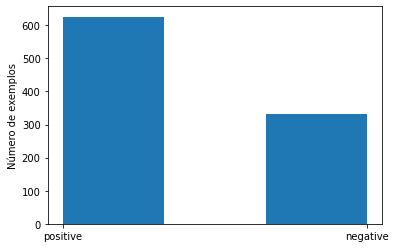

In [5]:
# plota um histograma da distribuição de y.
plt.hist(y, bins=3)
plt.ylabel('Número de exemplos')
plt.show()

## 3. Implementação

A biblioteca Sklearn fornece um framework para auxiliar na construção de classificadores personalizados. Usando a classe `ClassifierMixin` como base, foi possível implementar um novo classificador e utilizar recursos já implementados no sklearn, como os métodos de avaliação de desempenho (acurácia, taxa de erro etc).

A implementação do método de boosting utilizou árvores `stumps` como classificadores fracos.
Deste modo, foram implementados os dois classificadores.

No geral, a construção dos classificadores exigiu a herança do `ClassifierMixin` e a implementação de alguns métodos, como fit, predict e o construtor.

A seguir, são relatados os detalhes de cada implementação.

### 3.1 Árvore Stump

Similar a uma árvore de decisão de profundidade 1, o stump irá realizar apenas uma única verificação a fim de predizer a classe de x.

O Stump recebe como entrada o valor a ser verificado e a feature.

Ademais, o stump também permite predizer todos os exemplos como positivo ou como negativo.

In [6]:
class Stump(ClassifierMixin):
    """Implementação da decision stump."""
    
    def __init__(self, value, feature=None):
        self.value   = value   # valor a ser comparado
        self.feature = feature # feature para o split
        
    def __repr__(self):
         return "Feature {} = Valor {}".format(self.feature, self.value)
        
    def is_value(self, x):
        """Verifica o valor do dado e indica a classe."""
        
        if self.feature != None:
            return ('positive' if x[self.feature] == self.value else 'negative')
        
        return self.value
    
    def predict(self, X):
        """Recebe um conjunto de exemplos e fornece a predição."""
        
        return([self.is_value(x) for x in X])

A função `generate_stumps` será utilizada no boosting para gerar todos os stumps possíveis.

Uma vez que o tratamento dos dados incluiu o one-hot encoder, cada atributo produziu 3 atributos. 
Ou seja, se o atributo $i$ possui (x), (o) e (b) como valores possíveis, então 3 atributos serão produzidos para representar $i$:

* 0, 0, 1 para representar o valor (x)
* 0, 1, 0 para representar o valor (o)
* 1, 0, 0 para representar o valor (b)

Tendo em vista que o dataset possui 9 atributos, teremos $9 \times 3 = 27$ atributos.

Cada atributo será avaliado com seus dois valores possíveis:

1. Atributo $i$ tem valor 1? se sim então prediz a classe `positive`, senão prediz como classe `negative`.
2. Atributo $i$ tem valor 0? se sim então prediz a classe `positive`, senão prediz como classe `negative`.

Teremos então $27 \times 2 = 54$ stumps para cada combinação atributo-valor.

Além disso, mais dois stumps adicionais são criados:

1. Assume todos os exemplos como `positive`.
2. Assume todos os exemplos como `negative`.

Assim, `generate_stumps` irá produzir **56 stumps**. Conforme relatado anteriormente, a solução suporta dados categóricos, por isso é capaz de operar mesmo sem o one-hot enconder, resultando em 29 stumps.

In [7]:
def generate_stumps(X, y):
    """Funcao responsavel por gerar todas as combinacoes de stumps."""
        
    stumps = [] # lista de stumps.
         
    classes = unique_labels(y)
        
    for i in range(X.shape[1]):
        values = np.unique(X[i])
            
        for j in values:
            stump = Stump(j, i)
            stumps.append(stump)
        
    # Gera os stumps para cada valor de classe.
    for j in classes:
        stump = Stump(j)
        stumps.append(stump)
            
    return stumps

### 3.2 Boosting

Finalmente, a classe `Boosting` implementa o algoritmo AdaBoost com árvores stumps.

O modelo proposto neste trabalho baseou-se na implementação do boosting apresentada em sala de aula.

O algoritmo recebe como entrada o número máximo de iterações, onde cada iteração $t$ irá produzir um preditor $h_t$:

h*(X) = $\alpha_1 \times h(X)_1$ + $\alpha_2 \times h(X)_2$ + ... + $\alpha_n \times h(X)_n$

A classe de X será dada pela soma ponderada por $\alpha$ das classificações, deste modo o preditor com o maior valor $\alpha$ associado será o preditor de maior importância durante a predição.

Em cada iteração, o preditor que minimiza o erro ponderado será selecionado:

$e_t = \sum_{i = 1}^{n} w_t^{(i)} \qquad \forall {h_t(i) \neq y(i)}$

Onde o erro $e_t$ na iteração $t$ será dado pela soma dos pesos $w_i$ do i-éssimo exemplo com erro de classificação.

Logo em seguida, o $\alpha$ da iteração t será atualizado pela regra:

$\alpha_t = \frac{1}{2} log \frac{1 - e_t}{e_t}$

Embora os pesos sejam iniciados com valor $1/n$, eles também passam por uma atualização após cada iteração:

$w_{t+1} = \frac{w_t}{z} \times e^{-\alpha_t \cdot h_t(x) \cdot y(x)}$

**Uma decisão de implementação foi a aceitação de stumps previamente selecionados.** Constatou-se uma melhora significativa quando o número de stumps foi superior a 56.

Por exemplo, selecionando apenas stumps não-selecionados, a acurácia obtida foi por volta de 75%.
Porém, ao permitir que um stump seja novamente selecionado (com outro valor de $\alpha$) a acurácia aumentou para 98% com 300 iterações.

In [8]:
class Boosting(ClassifierMixin):
    """Implementação do boosting."""
    
    def __init__(self, max_it=56, repeat=True):
        self.max_it = max_it # numero maximo de iteracoes
        self.repeat = repeat # indica se os stumps serão repetidos
        
    def get_params(self, deep=True):
        return {"max_it": self.max_it, "repeat": repeat}
    
    def fit(self, X, y):
        """Metodo responsavel por treinar o modelo."""
        
        n, m    = X.shape               # Dimensao de X
        stumps  = generate_stumps(X, y) # Gera todos os stumps
        weights = np.repeat(1.0/n, n)   # Pesos dos exemplos inicializados com 1/n.

        self.ensemble = [] # stump na iteracao t
        self.alpha    = [] # alpha na iteracao t
        self.error    = [] # erro na iteracao t
        
        for t in range(self.max_it):
            
            error = np.repeat(0.0, len(stumps)) # Erro empirico de cada modelo.
            
            # Seleciona o modelo h_i que minimize o erro empirico.
            for i in range(len(stumps)):
                
                prediction = stumps[i].predict(X)
                for j, prediction_, y_ in zip(range(n), prediction, y):
                    if prediction_ != y_:
                        error[i] += weights[j]
                
            h = min(range(len(error)), key=error.__getitem__) # index do stump.
            
            alpha = 1/2.0 * np.log((1.0 - error[h])/error[h]) # Calculo da importancia dos stumps.
            
            # Atualizacao dos pesos.
            prediction = stumps[h].predict(X)
            for j, prediction_, y_ in zip(range(n), prediction, y):
                
                if prediction_ != y_:
                    weights[j] = weights[j] * math.e **alpha  # Errado: expoente positivo
                else:
                    weights[j] = weights[j] * math.e **-alpha # correto: expoente negativo
            
            weights = weights/np.sum(weights) # Fator de normalizacao.
            
            if self.repeat:
                self.ensemble.append(stumps[h]) # caso deseje repetir stumps
            else:
                self.ensemble.append(stumps.pop(h)) # caso deseje selecionar 1 vez
                
            self.alpha.append(alpha)
            self.error.append(error[h])
                        
        return self
    
    def sign(self, x):
        """Metodo responsavel por avaliar os preditores."""
        positive = 0.0
        negative = 0.0
         
        for i in range(len(self.ensemble)):
            if self.ensemble[i].predict([x])[0] == 'positive':
                positive += self.alpha[i]
            else:
                negative += self.alpha[i]        
        
        return 'positive' if positive >= negative else 'negative'
        
    def predict(self, X):
        """Metodo responsavel por predizer a classe de X."""
                
        return [ self.sign(x) for x in X ]

### 3.3 Funções Auxiliares

A classe `Results` foi criada a fim de facilitar o processo de visualização dos resultados.

Esta classe irá armazenar os erros obtidos pelo classificador e ao final irá plotar um gráfico contendo a taxa de erro durante o treinamento (média de cada k-fold) e o teste. A curva do gráfico contém a média obtida no treinamento de cada kfold juntamente com o desvio padrão.

Ademais, também foi analisado o erro obtido em cada iteração $e_t$ (erro ponderado).

In [9]:
class Results(object):
    
    def __init__(self):
        self.erro_mean     = [] # Media da taxa de erro
        self.erro_std      = [] # Desvio padrao da taxa de erro
        self.weighted_mean = [] # Media do erro ponderado
        self.weighted_std  = [] # Desvio padrao do erro ponderado
        
    def plot_erro(self, x, teste):
        """Plota um grafico contendo os resultados"""
        
        plt.figure()
        mean = np.array(self.erro_mean)
        std = np.array(self.erro_std)
        plt.plot(x, mean, label="Erro no treino")
        plt.fill_between(x, mean-std,mean+std,alpha=.1)
        
        mean = np.array(self.weighted_mean)
        std = np.array(self.weighted_std)
        plt.plot(x, mean, label="Erro ponderado")
        plt.fill_between(x, mean-std,mean+std,alpha=.1)
        
        plt.plot(x, teste, alpha=0.3, linewidth=2, label="Erro no teste")
        
        plt.ylim(0.0, 0.5)
        plt.legend(loc='center right')
        plt.xlabel("Número de preditores")
        plt.ylabel("Taxa de Erro")

A função `experimentos` recebe como entrada o classificador e o conjunto de parâmetros.

Esta função é responsável por treinar o modelo em cada parâmetro usando a validação cruzada (5 partições), coletar os resultados e chamar a função responsável pelo plot.

In [10]:
def experimentos(repeat, parametros):
    """Função responsavel por executar o boosting com um conjunto de parametros"""
    results = Results()
    teste = []
    
    for i in parametros:
        
        clf = Boosting(max_it=i, repeat=repeat)

        erro = []
        weighted = []

        # treina 5 folds
        skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

        for train_index, test_index in skf.split(X_train, y_train):
            X_train_, X_test_ = X_train[train_index], X_train[test_index]
            y_train_, y_test_ = y_train.iloc[train_index], y_train.iloc[test_index]

            clf.fit(X_train_, y_train_)

            # calcula os erros
            y_pred = clf.predict(X_test_)
            erro.append(np.mean(y_pred != y_test_))

            weighted.append(clf.error[len(clf.error)-1])

        # Guarda os resultados
        results.erro_mean.append(np.mean(erro))
        results.erro_std.append(np.std(erro))
        results.weighted_mean.append(np.mean(weighted))
        results.weighted_std.append(np.std(weighted))

        # Calcula o erro no teste
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        teste.append(np.mean(y_pred != y_test))

    # plota o grafico        
    results.plot_erro(parametros, teste)

## 4. Resultados

O objetivo dos experimentos foi analisar o comportamento da taxa de erro simples a medida em que mais preditores são inseridos no ensemble. Para tal, o número de preditores foi variado de 1 a 400:

* max_it = {1, 10, 20, ..., 400}

O boosting foi treinado em cada parâmetro utilizando a validação cruzada com 5 folds.

Em resumo, os resultados reportados mostram:

**O erro ponderado, isto é, o erro obtido no i-éssimo preditor aumenta conforme o número de iterações**

Cada preditor realiza erros diferentes de outros preditores selecionados. O primeiro preditor é aquele de menor erro, em seguida novos preditores são treinados dando um peso maior aos exemplos classificados incorretamente e pesos menores aos exemplos classificados corretamente.

Note que os classificadores subsequentes possuem uma taxa de erro maior, porém, são ajustados de modo a tentar classificar corretamente os exemplos incorretos da iteração anterior.

Em contrapartida, o erro no treino e no teste diminuem.

**A taxa de erro no treinamento e no teste diminuem gradativamente de acordo com a inserção de preditores fracos**

O algoritmo de boosting visa melhorar a performance de classificadores fracos mediante o uso de ensemble.
Estes modelos fracos com baixa variância são combinados iterativamente para formar um modelo forte, reduzindo o viés.

Este resultado é bem interessante, pois tomando um classificador fraco como base, é possível combinar múltiplas classificações e ter um modelo forte menos suscetível ao overfitting.

Isto é evidente ao analisar a curva do erro do teste. Mesmo quando treinado no conjunto de treino (sem o k-fold), o erro no teste seguiu a mesma tendência do erro registrado na validação cruzada.

**Após 300 iterações, a taxa de erro estabiliza-se no treino e no teste, onde a acurácia fica acima de 98%**

Em cada iteração, um stump é associado a um coeficiente $\alpha$. Um coeficiente alto sugere que aquele stump cometeu poucos erros durante o treinamento. Em contrapartida, um stump com coeficiente baixo (possivelmente negativo) sugere que este cometeu diversas classificações incorretas, onde ele considerou uma classe positiva quando na verdade era negativa.

Inicialmente, optou-se por tentar implementar o boosting sem repetição de stumps. Contudo, o desempenho do modelo não foi tão bom. A taxa de erro ficou acima de 20%.

Os resultados mostraram que é possível obter uma taxa de erro abaixo de 2% quando mais de 200 stumps são combinados. Embora stumps previamente selecionados tenham sido incluindos no ensemble, eles foram treinados com outros conjuntos de treinamento (erro ponderado) e portanto receberam um outro coeficiente de importância $\alpha$.

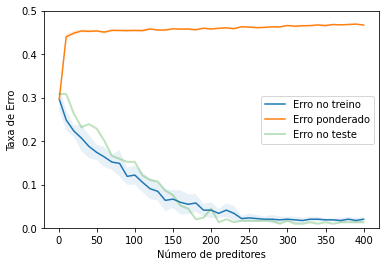

In [11]:
parametros = list([1]) +list(range(10, 410, 10)) # parametros avaliados
    
experimentos(True, parametros) # com repeticao de stumps

A seguir, são mostrados os 5 primeiros preditores inseridos no ensemble juntamente com os coeficientes de importância associado a cada preditor.

Por exemplo, o preditor $0.2784 \times h_1$ (X) teve uma importância 0.2784 e classifica um exemplo X como `positive` quando o atributo 1 tem valor 0. 

In [12]:
clf = Boosting(max_it=300, repeat=True)

clf.fit(X_train, y_train)

print("Top 5 preditores:")
[print(i) for i in clf.ensemble[1:6]]
print()
print("Top 5 alfa:")
[print(i) for i in clf.alpha[1:6]]

Top 5 preditores:
Feature 7 = Valor 0.0
Feature 1 = Valor 0.0
Feature 19 = Valor 0.0
Feature 25 = Valor 0.0
Feature 14 = Valor 1.0

Top 5 alfa:
0.32136016504670684
0.297300835062417
0.2968856988196131
0.2632687545105961
0.2211698722165172


[None, None, None, None, None]

O código a seguir detalha os experimentos por meio da análise de outras métricas.

O boosting treinado com 300 stumps teve uma acurácia média de 98.30%. Além disso, a precisão e a revocação foram próximas de 100%. Estes resultados mostram que o classificador acerta a maioria dos exemplos classificados como `positive`, e além disso, erra muito pouco ao classificar como `positive` um exemplo `negative`.

Embora as classes sejam desbalanceadas, o F-1 score foi de quase 100%.

In [13]:
clf = Boosting(max_it=300, repeat=True) # com repeticao

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds

i = 1
for train_index, test_index in skf.split(X, y):
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

    clf.fit(X_train,y_train) # treinamento
    y_pred = clf.predict(X_test)
            
    # calcula todos os scores
    
    #print("Número do fold:", i)
    #print("Acurácia: {:.3f}".format(accuracy_score(y_test, y_pred))) # acurácia
    #print("Precision: {:.3f}".format(precision_score(y_test, y_pred, pos_label='positive', zero_division=0)))
    #print("Recall: {:.3f}".format(recall_score(y_test, y_pred, pos_label='positive', zero_division=0)))
    #print("F1: {:.3f}".format(f1_score(y_test, y_pred, pos_label='positive', zero_division=0)))
    #print()
    i += 1

Fold  | Acurácia | Precisão | Revocação | F1-Score
---------  | ------ | ------ | ------ | ------
1  | 0.990 | 0.984 | 1.000 | 0.992
2 | 0.969 | 0.954 | 1.000 | 0.977
3    | 0.990 | 0.984 | 1.000 | 0.992
4 | 0.990 | 0.984 | 1.000 |0.992
5     | 0.974 | 0.969   | 0.992  |  0.980
Média | 0.983 | 0.975   | 0.998  |  0.986

O gráfico a seguir mostra o boosting quando os stumps não são repetidos. Neste caso, o número de iterações foi variado de 1 a 56 (máximo permitido).

No geral, a taxa de erro no treino e no teste permaneceu na faixa dos 20 ~ 30%.

Além disso, o erro ponderado ultrapassou 50% quando mais de 30 preditores foram utilizados.

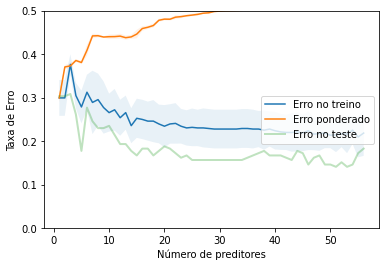

In [14]:
parametros = range(1, 57) # parametros avaliados
    
experimentos(False, parametros) # sem repeticao de stumps

Claramente, a primeira implementação teve um desempenho melhor. Em ambos os casos o comportamento do AdaBoost foi o mesmo. O erro ponderado aumenta com o número de iterações a medida em que os erros no treino/teste diminuem.

Este comportamento vai de acordo com o que foi mencionado antes. O preditor que minimiza o erro é selecionado de antemão, por isso ele é aquele de menor erro. A medida em que os preditores melhores são selecionados, sobram aqueles com taxa de erro maior.

Porém, o ajuste de importância atua ponderando a classificação de cada preditor, onde um preditor pode contribuir com uma classificação correta em casos onde outro preditor errou.

## 5. Conclusão
Neste trabalho foi implementado um algoritmo de boosting para um problema de classificação binária com atributos categóricos. Os experimentos utilizaram um conjunto de dados `tic-tac-toe`, que descreve diferentes configurações de um tabuleiro do jogo da velha.

Os resultados relatados mostraram uma acurácia média de aproximadamente 98% na validação cruzada, onde a taxa de erro simples chegou a cerca de 2%. Para tal, árvores stumps foram utilizadas como algoritmo base, em que o modelo construído com 300 preditores obtive o melhor resultado.

Foi possível compreender os conceitos fundamentais por trás da implementação de boosting e de que modo o número de preditores afeta a performance do modelo. Por meio da combinação de modelos fracos, foi possível obter um modelo forte que não "overfitta", melhorando o alto viés do stump, mas mantendo uma baixa variância.